In [24]:
### **Install the Libraries**

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import date

In [26]:
# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [27]:
# Free up unused cached memory
if device == 'cuda':
    torch.cuda.empty_cache()

In [28]:
# Ticker symbol for S&P 500
ticker = "^GSPC"

#yyyy-mm-dd
start_date = "1957-03-04"
end_date = date.today().strftime('%Y-%m-%d')

In [29]:
import os

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current Working Directory:", cwd)

def download_needed_data_to_csv(start_date: str, end_date:str) -> None:
    yf.download(ticker, start=start_date, end=end_date, interval='1d').to_csv('../training_data/s&p500.csv')

download_needed_data_to_csv(start_date, end_date)

[*********************100%***********************]  1 of 1 completed

Current Working Directory: m:\programming\my_projects\gsm_model\py


In [30]:
all_data = pd.read_csv("../training_data/s&p500.csv")

m:\programming\my_projects\environments\dachat\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


<Figure size 1000x600 with 0 Axes>

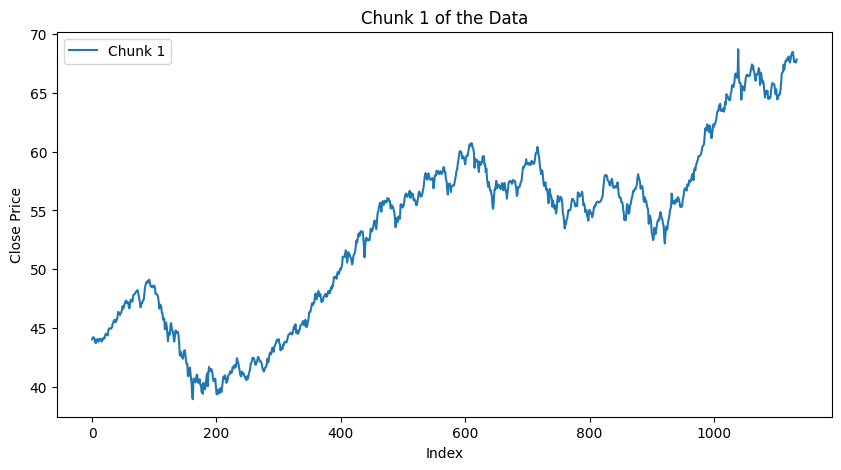

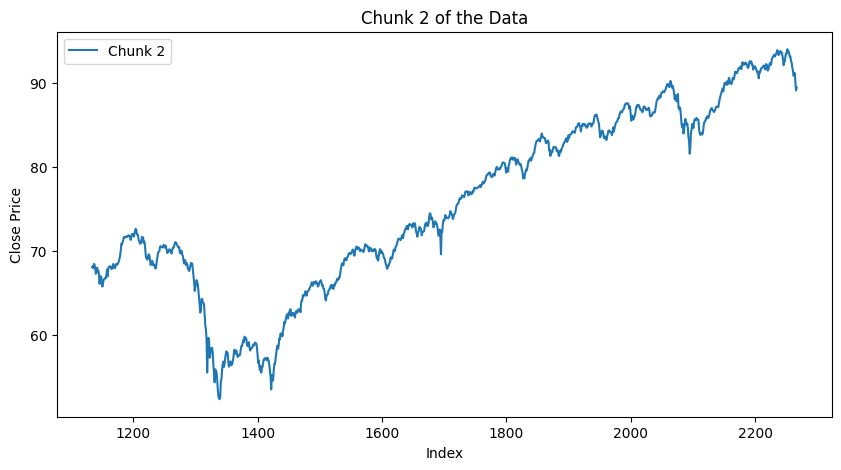

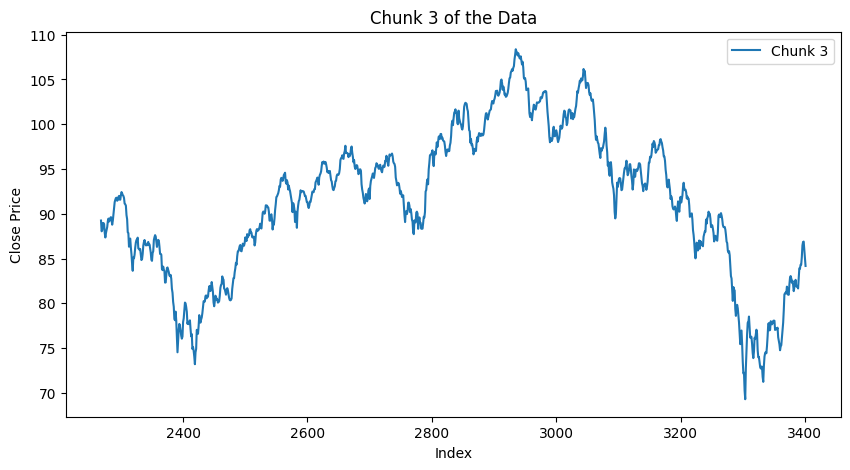

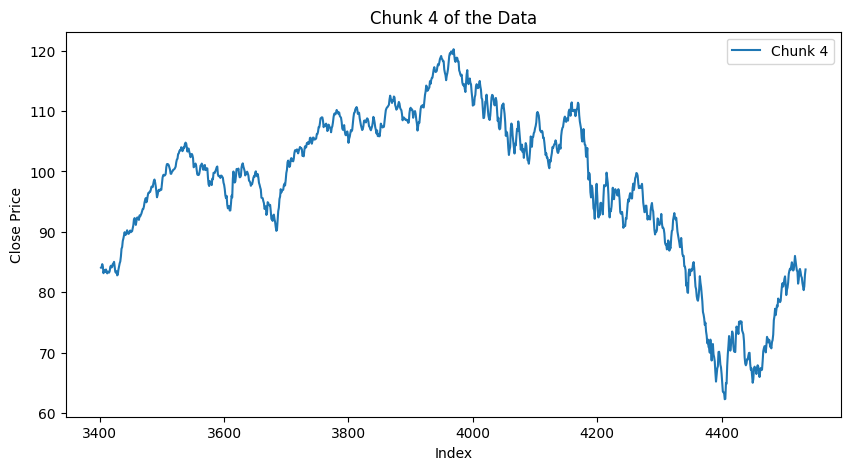

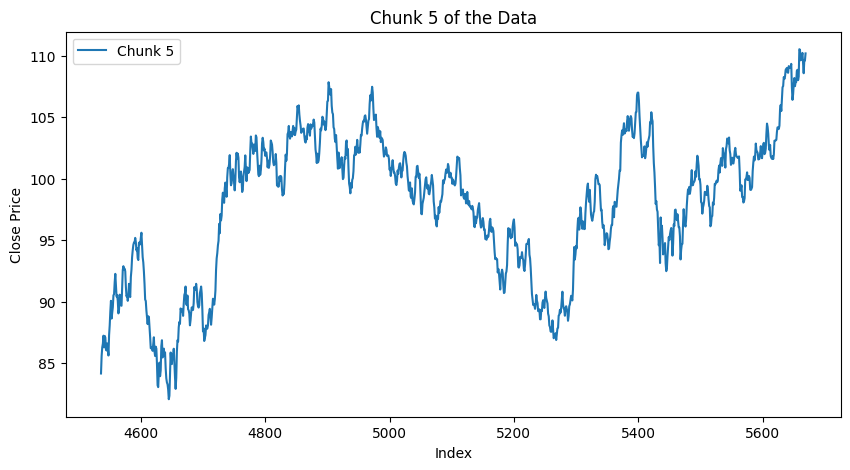

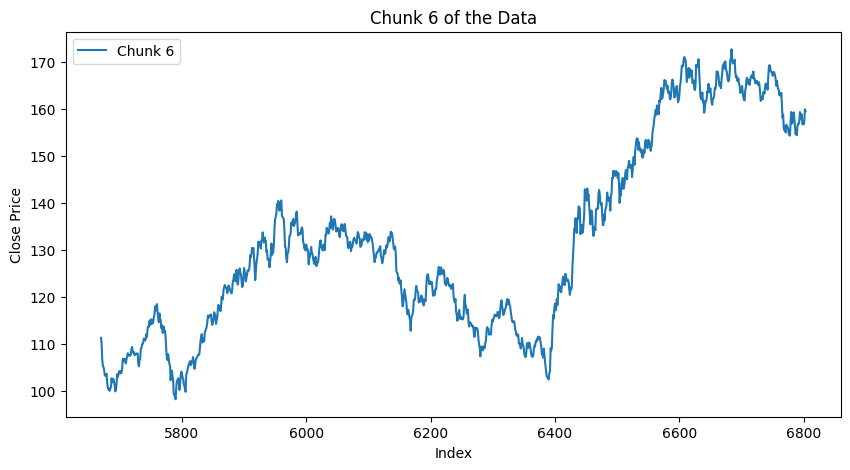

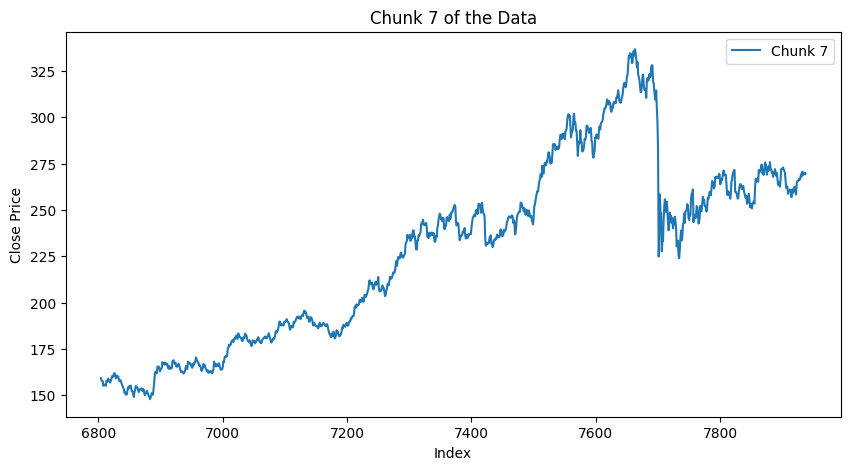

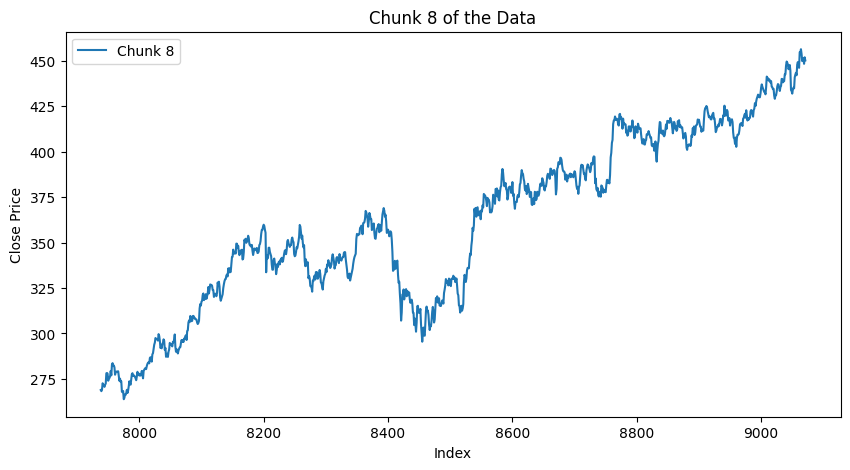

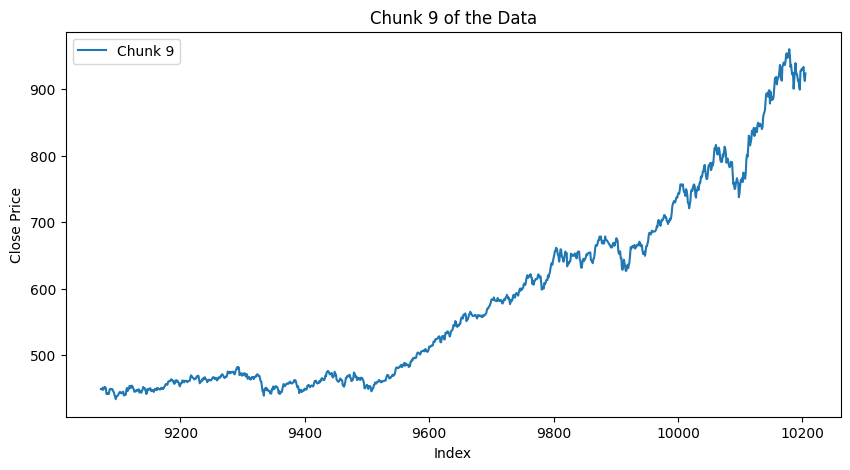

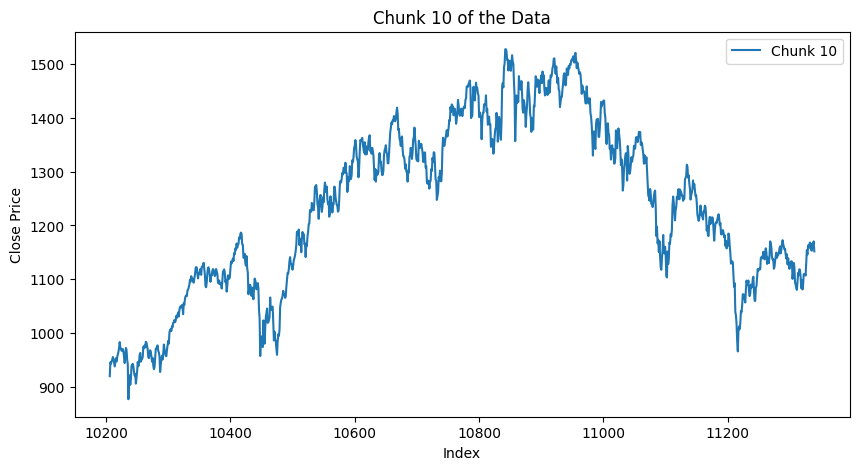

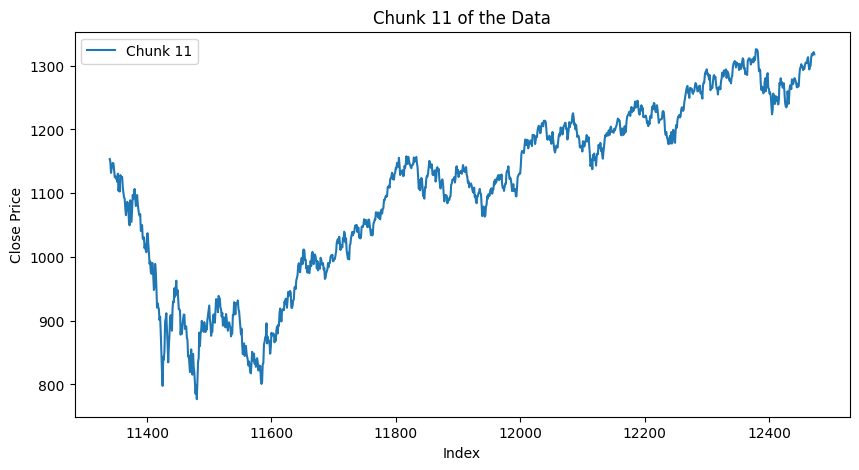

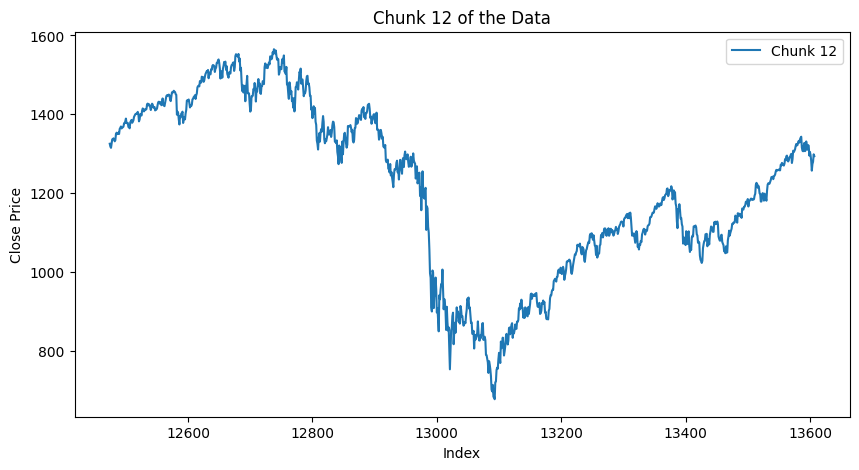

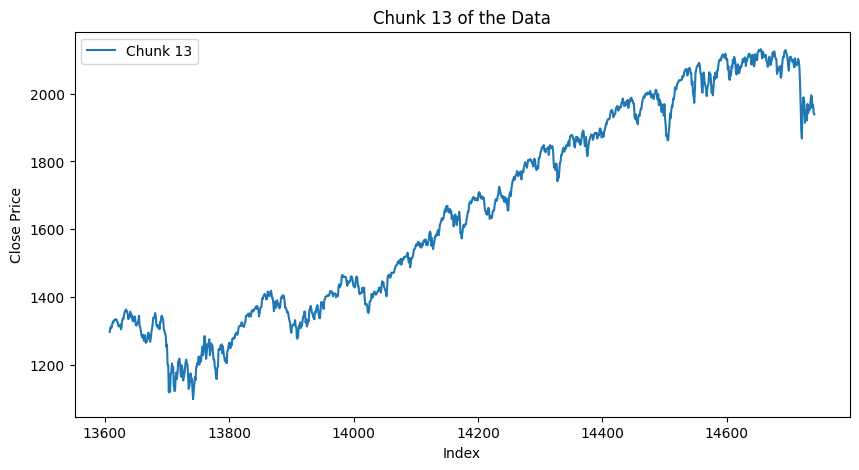

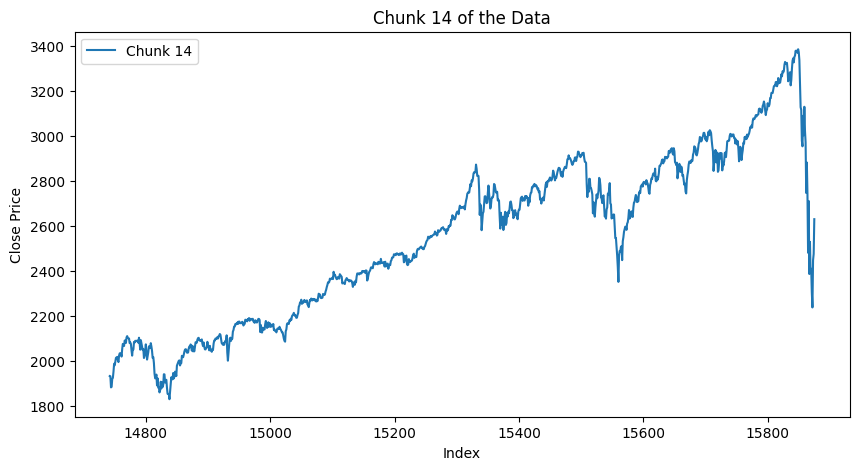

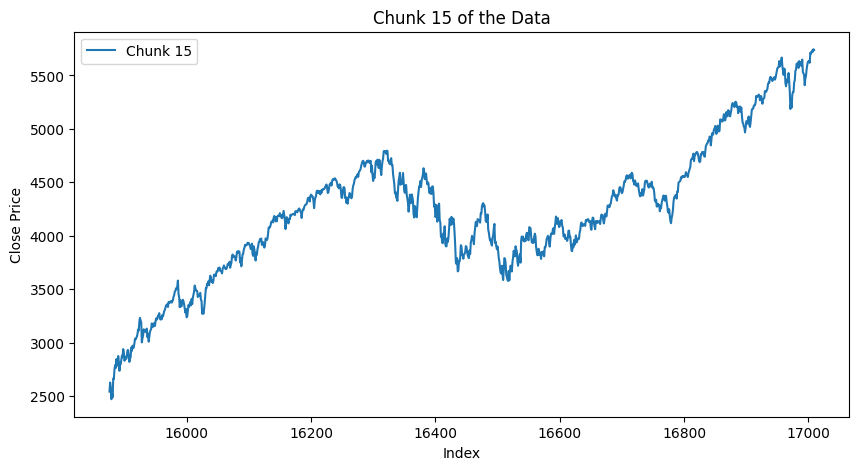

In [31]:
chunks = np.array_split(all_data, 15)

# Create a plot
plt.figure(figsize=(10, 6))

for i, chunk in enumerate(chunks):
    plt.figure(figsize=(10, 5))
    
    # Assuming you want to plot one column (e.g., 'Close')
    plt.plot(chunk.index, chunk['Close'], label=f'Chunk {i+1}')
    
    # Add title and labels
    plt.title(f'Chunk {i+1} of the Data')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.legend()
    
    # Show the plot
    plt.show()

In [32]:
all_data_copy = all_data.drop('Date', axis=1)
corr_matrix = all_data_copy.corr()
print(corr_matrix['Close'].sort_values(ascending=False))

Close        1.000000
Adj Close    1.000000
Low          0.999969
High         0.999965
Open         0.999374
Volume       0.773402
Name: Close, dtype: float64


In [34]:
from sklearn.model_selection import train_test_split

#Setting train and label data
train_data = all_data.drop(['Date', 'Close', 'Adj Close'], axis=1)
labels = all_data['Close'].copy()

# Split the dataset: 80% train, 20% validation
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.20, random_state=42)

X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13608 entries, 11135 to 15795
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    13608 non-null  float64
 1   High    13608 non-null  float64
 2   Low     13608 non-null  float64
 3   Volume  13608 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 531.6 KB
<class 'pandas.core.frame.DataFrame'>
Index: 3402 entries, 4894 to 16362
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3402 non-null   float64
 1   High    3402 non-null   float64
 2   Low     3402 non-null   float64
 3   Volume  3402 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 132.9 KB


In [35]:
# Format datasets for PyTorch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def format_data_for_torch(data_x: pd.DataFrame, data_y: pd.DataFrame) -> DataLoader:
    data_x_tensor = torch.FloatTensor(data_x.values)
    data_y_tensor = torch.FloatTensor(data_y.values)
    dataset = CustomDataset(data_x_tensor, data_y_tensor)
    return DataLoader(dataset=dataset, batch_size=32, shuffle=True)

train_loader = format_data_for_torch(X_train, y_train)
test_loader = format_data_for_torch(X_test, y_test)